# Quickstart Example with Synthetic Recommender Simulation (Customization)
This notebook provides an example of customizing the Recommender environment.

This example on the Synthetic Recommender Simulation consists of the following 3 steps:
1. Setup Synthetic Recommender Simulation Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [107]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [109]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [110]:
# import OFRL modules
import ofrl
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead

# import recgym modules
# import recgym
from recgym import RECEnv
from rtbgym import RTBEnv
from recgym import UserModel

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy

# import from other libraries
import gym

from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

In [111]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [112]:
# version
print(ofrl.__version__)

0.0.0


In [113]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 1. Setup Synthetic Recommender Simulation Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Recommendation
In recommendation, the objective of the RL agent is to maximize reward

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, you can gain observation instead of state.
- `action`:  Index of an item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.

Let's see how it works!

In [114]:
# setup environment
env = gym.make('RECEnv-v0')

In [115]:
# define a random agent
agent = DiscreteEpsilonGreedyHead(
      base_policy = DiscreteRandomPolicy(),
      name = 'random',
      n_actions = env.n_items,
      epsilon = 1. ,
      random_state = random_state, 
)

In [116]:
print(agent)
print(env.action_space)
print(env.n_items)
print(env.n_users)
print(env.action_space.n)
print(env.observation_space)

DiscreteEpsilonGreedyHead(base_policy=d3rlpy.algos.random_policy.DiscreteRandomPolicy(action_scaler=None, action_size=1, batch_size=1, gamma=0.0, generated_maxlen=100000, impl=None, n_frames=1, n_steps=1, real_ratio=1.0, reward_scaler=None, scaler=None), name='random', n_actions=100, epsilon=1.0, random_state=12345)
Discrete(100)
100
100
100
Box(-1.0, 1.0, (5,), float64)


In [117]:
import ofrl
from ofrl.ope.online import calc_on_policy_policy_value
# calculate on-policy policy value
on_policy_performance = calc_on_policy_policy_value(
  env,
  agent,
  # n_episodes=100,
  n_trajectories=100,
  random_state=12345
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [118]:
print(on_policy_performance)

4.98


In [119]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [120]:
# state 
print(obs.shape)
print(obs)

(5,)
[-0.04552487  0.1208106   0.11597855  0.14365492 -0.15756327]


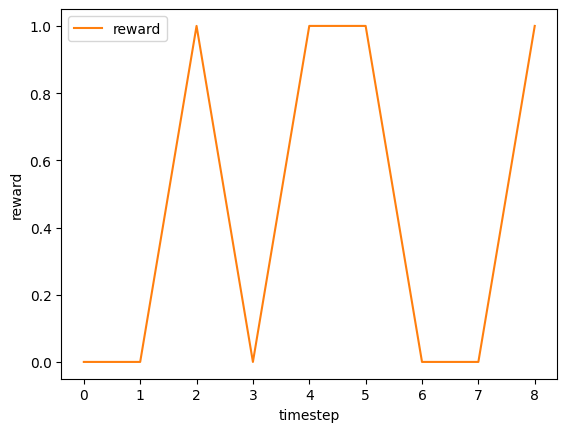

In [121]:
# let's visualize the transition of reward
def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)

        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 1. Standardized Environment

We provide standardize recommender environment

In [122]:
env = RECEnv(random_state=12345)

## 2. Customize Environmental Configuration
Now, we customize the recommender simulation environment.

We have the following environmental configurations:
- `UserModel`: User model which defines user_prefecture_dynamics and reward_function.
- `n_items`: Number of items used for recommendation.
- `n_users`: Number of users used for recommendation.
- `item_feature_dim`: Dimensions of the item feature vectors.
- `user_feature_dim`: Dimensions of the user feature vectors.
- `item_feature_vector`: Feature vectors that characterizes each item.
- `user_feature_vector`: Feature vectors that characterizes each user.
- `reward_type`: Reward type (i.e., countinuous / binary).
- `reward_std`: Standard deviation of the reward distribution. Applicable only when reward_type is "continuous".
- `obs_std`: Standard deviation of the observation distribution.
- `step_per_episode`: Number of timesteps in an episode.
- `random_state` : Random state

#### Case 1. Customizing the Basic Setup

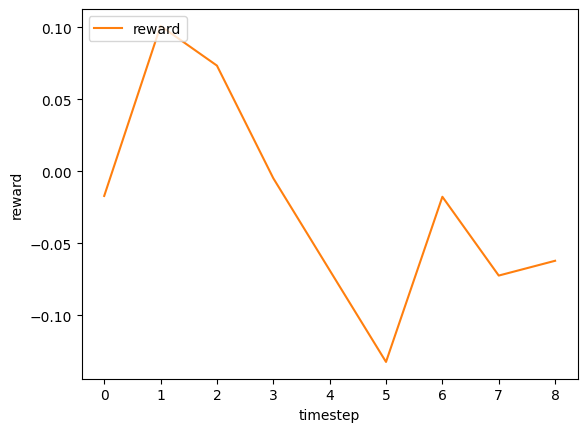

In [123]:
env = RECEnv(
        UserModel = UserModel,
        n_items = 100,  # we use 100 items
        n_users = 100,  # 100 users exists
        item_feature_dim = 5,  #each item has 5 dimensional features
        user_feature_dim = 5,  #each user has 5 dimensional features
        item_feature_vector = None,  #determine item_feature_vector from n_items and item_feature_dim in RECEnv
        user_feature_vector = None,  #determine user_feature_vector from n_users and user_feature_dim in RECEnv
        reward_type = "continuous", #we use continuous reward
        reward_std = 0.0,
        obs_std = 0.0, #not add noise to the observation
        step_per_episode = 10,
        random_state = 12345,
)
visualize_interaction_on_environment(env, agent)

#### Case 2. Defining the Items and Users

In [124]:
# we use the following items for recommendation
item_features = np.sign(random_.normal(size=(100, 5))).astype(int)
item_names, feature_names = [f"ad{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
item_df = pd.DataFrame(item_features, columns=feature_names, index=item_names)
item_df

,feature1,feature2,feature3,feature4,feature5
ad1,-1,1,-1,-1,1
ad2,1,1,1,1,1
ad3,1,-1,1,1,1
ad4,1,-1,-1,1,-1
ad5,-1,1,1,-1,-1
...,...,...,...,...,...
ad96,1,-1,-1,-1,1
ad97,1,1,-1,1,1
ad98,-1,-1,1,1,-1
ad99,-1,1,-1,1,1


In [125]:
# we assume that the following 100 users 
user_features = np.sign(random_.normal(size=(100, 5))).astype(int)
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,-1,-1,-1,1,1
user2,-1,-1,1,1,-1
user3,-1,-1,1,1,-1
user4,1,1,1,1,1
user5,-1,-1,1,1,1
...,...,...,...,...,...
user96,-1,-1,-1,-1,1
user97,1,-1,1,1,-1
user98,1,-1,1,-1,-1
user99,-1,1,-1,1,-1


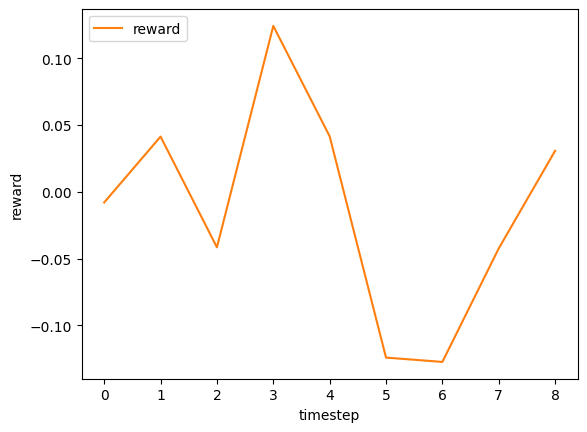

In [126]:
# using the above data, we can simulate an recommendation as follows
env = RECEnv(
        UserModel = UserModel,
        n_items = 100,  # we use 100 items
        n_users = 100,  # 100 users exists
        item_feature_dim = 5,  #each item has 5 dimensional features
        user_feature_dim = 5,  #each user has 5 dimensional features
        item_feature_vector = item_features, # use item features defined above
        user_feature_vector = user_features, # use user features defined above
        reward_type = "continuous", #we use continuous reward
        reward_std = 0.0,
        obs_std = 0.0, #not add noise to the observation
        step_per_episode = 10,
        random_state = 12345,
)
visualize_interaction_on_environment(env, agent)

#### Case 3. Using Customized UserModel(reward_function)

In [127]:
from recgym import BaseUserModel
from recgym import Action

@dataclass
class UserModel(BaseUserModel):
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    item_feature_vector: Optional[np.ndarray] = None,
    random_state: Optional[int] = None

    def __post_init__(self):
        check_scalar(
            self.reward_std,
            name="reward_std",
            target_type=float,
        )

        if self.reward_type not in ["continuous", "binary"]:
            raise ValueError(
                f'reward_type must be either "continuous" or "binary", but {self.reward_type} is given'
            )

        self.random_ = check_random_state(self.random_state)

    def user_preference_dynamics(
        self,
        state: np.ndarray,
        action: Action,
        alpha: float = 1.0,
    )-> np.ndarray:
        
        check_scalar(
            state,
            name="state",
            target_type=np.ndarray,
        )
        check_scalar(
            action,
            name="action",
            target_type=Action,
        )

        state = (state + alpha * state @ self.item_feature_vector[action] * self.item_feature_vector[action])
        state = state / np.linalg.norm(state, ord=2)
        return state

    def reward_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        reward = self.cos_similar_function(state, action)

        if self.reward_type is "continuous":
            reward = reward + self.random_.normal(loc=0.0, scale=self.reward_std)

        return reward

    def cos_similar_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        inner = state @ self.item_feature_vector[action]
        reward = inner / (np.linalg.norm(state, ord=2) * np.linalg.norm(self.item_feature_vector[action], ord=2))

        return reward

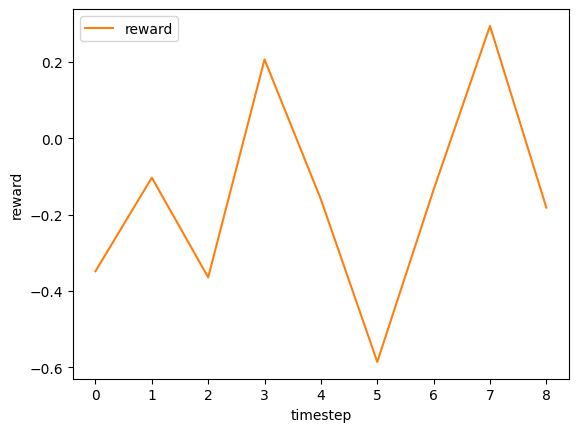

In [128]:
# setup environment
env = RECEnv(
    UserModel = UserModel,
    reward_type = "continuous",
    random_state=12345
)
visualize_interaction_on_environment(env, agent)


#### Case 4. Using Customized UserModel(user_preference_dynamics and reward_function)

In [129]:
from recgym import BaseUserModel
from recgym import Action

@dataclass
class UserModel(BaseUserModel):
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    item_feature_vector: Optional[np.ndarray] = None,
    random_state: Optional[int] = None

    def __post_init__(self):
        check_scalar(
            self.reward_std,
            name="reward_std",
            target_type=float,
        )

        if self.reward_type not in ["continuous", "binary"]:
            raise ValueError(
                f'reward_type must be either "continuous" or "binary", but {self.reward_type} is given'
            )

        self.random_ = check_random_state(self.random_state)

    def user_preference_dynamics(
        self,
        state: np.ndarray,
        action: Action,
        alpha: float = 1.0,
    )-> np.ndarray:
        
        check_scalar(
            state,
            name="state",
            target_type=np.ndarray,
        )
        check_scalar(
            action,
            name="action",
            target_type=Action,
        )

        if self.reward == 1:
            state = (state + alpha * state @ self.item_feature_vector[action] * self.item_feature_vector[action])
            state = state / np.linalg.norm(state, ord=2)
            
        return state

    def reward_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        self.reward = self.random_.binomial(n=1, p=self.sigmoid(self.cos_similar_function(state, action)))

        if self.reward_type is "continuous":
            reward = reward + self.random_.normal(loc=0.0, scale=self.reward_std)

        return self.reward

    def cos_similar_function(
        self,
        state: np.ndarray,
        action: Action,
    )-> float:
        inner = state @ self.item_feature_vector[action]
        reward = inner / (np.linalg.norm(state, ord=2) * np.linalg.norm(self.item_feature_vector[action], ord=2))

        return reward
    
    def sigmoid(self, x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    # Sigmoid function
        return 1 / (1 + np.exp(-x))

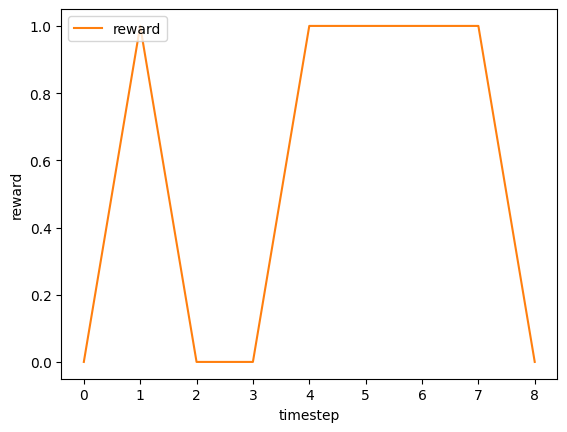

In [130]:
# setup environment
env = RECEnv(
    UserModel = UserModel,
    reward_type = "binary",
    random_state=12345
)
visualize_interaction_on_environment(env, agent)


## Reference
- Sarah Dean, Jamie Morgenstern. \
"Preference Dynamics Under Personalized Recommendations.", 2022.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- David Rohde, Stephen Bonner, Travis Dunlop, Flavian Vasile, Alexandros Karatzoglou. \
"RecoGym: A Reinforcement Learning Environment for the Problem of Product Recommendation in Online Advertising." 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.